IMPORTS

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoConfig,
    get_cosine_schedule_with_warmup
)
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from tqdm.auto import tqdm
import re
import os
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


PyTorch version: 2.7.1+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 5090
GPU Memory: 34.2 GB


CONFIGURATION

In [ ]:
from dataclasses import dataclass

@dataclass
class Config:
    # Data paths
    RAW_CSV_PATH: str = 'training.1600000.processed.noemoticon.csv'
    OUTPUT_DIR: str = './outputs'

    # MODEL
    MODEL_NAME: str = "roberta-large"

    # Tokenization
    MAX_LEN: int = 96

    # TRAINING
    BATCH_SIZE: int = 128  #
    ACCUMULATION_STEPS: int = 2
    LEARNING_RATE: float = 1e-5
    WEIGHT_DECAY: float = 0.01
    EPOCHS: int = 8
    WARMUP_RATIO: float = 0.06
    MAX_GRAD_NORM: float = 1.0

    # Advanced training
    USE_LLRD: bool = True
    LLRD_FACTOR: float = 0.9

    # Regularization
    DROPOUT: float = 0.1
    ATTENTION_DROPOUT: float = 0.1
    HIDDEN_DROPOUT: float = 0.1

    # Data augmentation
    USE_AUGMENTATION: bool = True
    AUG_PROBABILITY: float = 0.2

    # Precision
    USE_AMP: bool = True
    AMP_DTYPE: str = "bfloat16"

    # Early stopping
    PATIENCE: int = 3

    # Hardware
    NUM_WORKERS: int = 0
    PIN_MEMORY: bool = True

# Create config
config = Config()


print(f"\n MODEL:")
print(f"  Name: {config.MODEL_NAME}")
print(f"  Max length: {config.MAX_LEN}")

print(f"\n TRAINING (MEMORY OPTIMIZED):")
print(f"  Batch size: {config.BATCH_SIZE}")
print(f"  Accumulation steps: {config.ACCUMULATION_STEPS}")
print(f"  Effective batch: {config.BATCH_SIZE * config.ACCUMULATION_STEPS}")
print(f"  Learning rate: {config.LEARNING_RATE}")
print(f"  Epochs: {config.EPOCHS}")

print(f"\ OPTIMIZATION:")
print(f"  Mixed precision: {config.USE_AMP} ({config.AMP_DTYPE})")
print(f"  LLRD: {config.USE_LLRD}")
print(f"  Dropout: {config.DROPOUT}")



 MODEL:
  Name: roberta-large
  Max length: 96

 TRAINING (MEMORY OPTIMIZED):
  Batch size: 128
  Accumulation steps: 2
  Effective batch: 256
  Learning rate: 1e-05
  Epochs: 8
\ OPTIMIZATION:
  Mixed precision: True (bfloat16)
  LLRD: True
  Dropout: 0.1


In [ ]:
# GPU SETUP & OPTIMIZATION

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    # Enable TF32 for faster computation on Ampere+ GPUs
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

    # Enable cuDNN benchmark for faster training
    torch.backends.cudnn.benchmark = True

    # Set memory allocation strategy
    torch.cuda.set_per_process_memory_fraction(0.95)  # Use 95% of GPU


    print(f"✓ TF32 enabled")
    print(f"✓ cuDNN benchmark enabled")
    print(f"✓ Memory fraction: 95%")
    print(f"✓ Device: {torch.cuda.get_device_name(0)}")

else:
    print("Warning: CUDA not available, using CPU")

✓ TF32 enabled
✓ cuDNN benchmark enabled
✓ Memory fraction: 95%
✓ Device: NVIDIA GeForce RTX 5090


In [ ]:
# LOAD RAW DATA

cols = ['polarity', 'id', 'date', 'query', 'user', 'text']
raw_df = pd.read_csv(config.RAW_CSV_PATH, encoding='latin-1', header=None, names=cols)

print(f"\n✓ Loaded {len(raw_df):,} tweets")

# Convert labels: 0 (negative) stays 0, 4 (positive) becomes 1
raw_df['label'] = raw_df['polarity'].map({0: 0, 4: 1})

print(f"\n Class distribution:")
print(raw_df['label'].value_counts().sort_index())

# Keep only text and label
df = raw_df[['text', 'label']].copy()


✓ Loaded 1,600,000 tweets

 Class distribution:
label
0    800000
1    800000
Name: count, dtype: int64


In [ ]:
# TEXT PREPROCESSING

import re

# Emoticon mappings
EMOTICONS = {
    ':)': '<HAPPY>', ':-)': '<HAPPY>', ':]': '<HAPPY>', ':D': '<HAPPY>',
    ':(': '<SAD>', ':-(': '<SAD>', ':[': '<SAD>',
    ':P': '<LAUGH>', ':-P': '<LAUGH>',
    ';)': '<WINK>', ';-)': '<WINK>',
    '<3': '<LOVE>',
    ":'(": '<CRYING>', ':,(': '<CRYING>',
    ':@': '<ANGRY>',
    ':/': '<SKEPTICAL>', ':-/': '<SKEPTICAL>',
}

def preprocess_tweet(text):
    """Preprocess tweet text for sentiment analysis"""

    # Convert to lowercase first for URL/mention detection
    text_lower = text.lower()

    # Extract emoticons BEFORE lowercasing (they're case-sensitive!)
    original_text = text
    for emoticon, token in EMOTICONS.items():
        original_text = original_text.replace(emoticon, f' {token} ')

    # Now work with the text
    text = original_text.lower()

    # Replace URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '<URL>', text)

    # Replace mentions
    text = re.sub(r'@\w+', '<USER>', text)

    # Replace hashtags (keep the word)
    text = re.sub(r'#(\w+)', r'<HASHTAG> \1', text)

    # Normalize repeated characters (looove -> love)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # Detect emphasis (ALL CAPS words)
    words = text.split()
    processed_words = []
    for word in words:
        if word.isupper() and len(word) > 2 and not word.startswith('<'):
            processed_words.append('<SHOUT>')
            processed_words.append(word.lower())
        else:
            processed_words.append(word)
    text = ' '.join(processed_words)

    # Clean up whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
# PREPROCESS ALL TWEETS

from tqdm import tqdm
tqdm.pandas()

# Apply preprocessing
print("\nApplying preprocessing...")
df['clean_text'] = df['text'].progress_apply(preprocess_tweet)

print(f"\n✓ Preprocessing complete!")

# Show examples
print(f"\n Examples:")
for i in range(3):
    print(f"\n{i+1}. Original: {df['text'].iloc[i][:80]}...")
    print(f"   Cleaned:  {df['clean_text'].iloc[i][:80]}...")


Applying preprocessing...


100%|██████████| 1600000/1600000 [00:11<00:00, 144203.44it/s]


✓ Preprocessing complete!

 Examples:

1. Original: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got D...
   Cleaned:  <USER> http <skeptical> /twitpic.com/2y1zl - a<URL> that's a bummer. you shoulda...

2. Original: is upset that he can't update his Facebook by texting it... and might cry as a r...
   Cleaned:  is upset that he can't update his facebook by texting it.. and might cry as a re...

3. Original: @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out ...
   Cleaned:  <USER> i dived many times for the ball. managed to save 50% the rest go out of b...


In [ ]:
# LOAD TOKENIZER & ADD SPECIAL TOKENS

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME, use_fast=True)

print(f"\n✓ Loaded: {config.MODEL_NAME}")
print(f"  Base vocabulary: {len(tokenizer):,} tokens")

# Add special tokens
special_tokens = [
    '<HAPPY>', '<SAD>', '<LAUGH>', '<WINK>', '<LOVE>', '<CRYING>',
    '<ANGRY>', '<SKEPTICAL>', '<USER>', '<HASHTAG>', '<URL>',
    '<SHOUT>', '<EMPHASIS>', '<SARCASM>', '<QUESTION>'
]

special_tokens_dict = {'additional_special_tokens': special_tokens}
num_added = tokenizer.add_special_tokens(special_tokens_dict)

print(f"\n✓ Added {num_added} special tokens")
print(f"  New vocabulary: {len(tokenizer):,} tokens")
print(f"  Special tokens: {special_tokens[:5]}...")



✓ Loaded: roberta-large
  Base vocabulary: 50,265 tokens

✓ Added 15 special tokens
  New vocabulary: 50,280 tokens
  Special tokens: ['<HAPPY>', '<SAD>', '<LAUGH>', '<WINK>', '<LOVE>']...


In [ ]:
# DATASET CLASS

import random

class TweetDataset(Dataset):
    """Dataset for tweets with optional augmentation"""

    def __init__(self, texts, labels, tokenizer, max_length=160, augment=False, aug_probability=0.2):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.augment = augment
        self.aug_probability = aug_probability

    def __len__(self):
        return len(self.texts)

    def augment_text(self, text):
        """Simple augmentation: random word deletion"""
        if not self.augment or random.random() > self.aug_probability:
            return text

        words = text.split()
        if len(words) <= 3:
            return text

        # Preserve sentiment tokens
        sentiment_indices = [i for i, w in enumerate(words) if w.startswith('<') and w.endswith('>')]
        deletable_indices = [i for i in range(len(words)) if i not in sentiment_indices]

        if len(deletable_indices) <= 2:
            return text

        # Delete 10-20% of words
        num_to_delete = max(1, int(len(deletable_indices) * random.uniform(0.1, 0.2)))
        indices_to_delete = set(random.sample(deletable_indices, num_to_delete))

        augmented_words = [words[i] for i in range(len(words)) if i not in indices_to_delete]
        return ' '.join(augmented_words)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        if self.augment:
            text = self.augment_text(text)

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
# CREATE DATASETS & DATALOADERS

# Create datasets
print("\nCreating datasets...")

train_dataset = TweetDataset(
    texts=train_df['clean_text'].values,
    labels=train_df['label'].values,
    tokenizer=tokenizer,
    max_length=config.MAX_LEN,
    augment=True,
    aug_probability=config.AUG_PROBABILITY
)

val_dataset = TweetDataset(
    texts=val_df['clean_text'].values,
    labels=val_df['label'].values,
    tokenizer=tokenizer,
    max_length=config.MAX_LEN,
    augment=False
)

test_dataset = TweetDataset(
    texts=test_df['clean_text'].values,
    labels=test_df['label'].values,
    tokenizer=tokenizer,
    max_length=config.MAX_LEN,
    augment=False
)

print(f"✓ Train dataset: {len(train_dataset):,} samples")
print(f"✓ Val dataset: {len(val_dataset):,} samples")
print(f"✓ Test dataset: {len(test_dataset):,} samples")

# Create DataLoaders
print("\nCreating DataLoaders...")

train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,  # 128
    shuffle=True,
    num_workers=config.NUM_WORKERS,  # 0
    pin_memory=config.PIN_MEMORY,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE * 2,  # 256
    shuffle=False,
    num_workers=config.NUM_WORKERS,
    pin_memory=config.PIN_MEMORY
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE * 2,  # 256
    shuffle=False,
    num_workers=config.NUM_WORKERS,
    pin_memory=config.PIN_MEMORY
)

print(f"\n Train loader: {len(train_loader):,} batches")
print(f" Val loader: {len(val_loader):,} batches")
print(f" Test loader: {len(test_loader):,} batches")

print(f"\n Configuration:")
print(f"  Batch size: {config.BATCH_SIZE}")
print(f"  Val/Test batch: {config.BATCH_SIZE * 2}")
print(f"  Num workers: {config.NUM_WORKERS}")
print(f"  Augmentation: Training only")




Creating datasets...
✓ Train dataset: 1,280,000 samples
✓ Val dataset: 160,000 samples
✓ Test dataset: 160,000 samples

Creating DataLoaders...

 Train loader: 10,000 batches
 Val loader: 625 batches
 Test loader: 625 batches

 Configuration:
  Batch size: 128
  Val/Test batch: 256
  Num workers: 0
  Augmentation: Training only


In [ ]:
# MODEL COMPONENTS

class MultiSampleDropout(nn.Module):
    """Multi-sample dropout for regularization"""
    def __init__(self, hidden_size, num_labels, dropout_rate=0.1, num_samples=5):
        super().__init__()
        self.num_samples = num_samples
        self.dropout = nn.Dropout(dropout_rate)
        self.classifiers = nn.ModuleList([
            nn.Linear(hidden_size, num_labels) for _ in range(num_samples)
        ])

    def forward(self, x):
        logits_list = []
        for classifier in self.classifiers:
            dropped = self.dropout(x) if self.training else x
            logits = classifier(dropped)
            logits_list.append(logits)
        return torch.stack(logits_list).mean(dim=0)


class AttentionPooling(nn.Module):
    """Attention-based pooling"""
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1, bias=False)
        )

    def forward(self, hidden_states, attention_mask):
        scores = self.attention(hidden_states).squeeze(-1)
        scores = scores.masked_fill(attention_mask == 0, -1e9)
        weights = F.softmax(scores, dim=1).unsqueeze(-1)
        pooled = (hidden_states * weights).sum(dim=1)
        return pooled


class OptimizedSentimentModel(nn.Module):
    """Sentiment classification model"""

    def __init__(self, model_name: str, num_labels: int = 2, dropout: float = 0.1, use_multi_sample_dropout: bool = True):
        super().__init__()

        model_config = AutoConfig.from_pretrained(model_name)
        model_config.hidden_dropout_prob = dropout
        model_config.attention_probs_dropout_prob = dropout

        self.transformer = AutoModel.from_pretrained(model_name, config=model_config)
        self.transformer.resize_token_embeddings(len(tokenizer))

        hidden_size = model_config.hidden_size
        self.attention_pooling = AttentionPooling(hidden_size)

        combined_size = hidden_size * 4

        if use_multi_sample_dropout:
            self.classifier = nn.Sequential(
                nn.Linear(combined_size, hidden_size),
                nn.LayerNorm(hidden_size),
                nn.GELU(),
                nn.Dropout(dropout),
                MultiSampleDropout(hidden_size, num_labels, dropout_rate=dropout)
            )
        else:
            self.classifier = nn.Sequential(
                nn.Linear(combined_size, hidden_size),
                nn.LayerNorm(hidden_size),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_size, num_labels)
            )

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        hidden_states = outputs.last_hidden_state

        # Multi-pooling
        cls_output = hidden_states[:, 0, :]

        mask_expanded = attention_mask.unsqueeze(-1).expand(hidden_states.size()).float()
        sum_embeddings = torch.sum(hidden_states * mask_expanded, dim=1)
        sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
        mean_output = sum_embeddings / sum_mask

        hidden_states_masked = hidden_states.clone()
        hidden_states_masked[mask_expanded == 0] = -1e9
        max_output, _ = torch.max(hidden_states_masked, dim=1)

        attn_output = self.attention_pooling(hidden_states, attention_mask)

        pooled_output = torch.cat([cls_output, mean_output, max_output, attn_output], dim=-1)

        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss = F.cross_entropy(logits, labels, weight=class_weights)

        return {'loss': loss, 'logits': logits}



In [ ]:
# CREATE MODEL

# Create model
print(f"\nLoading: {config.MODEL_NAME}")
model = OptimizedSentimentModel(
    model_name=config.MODEL_NAME,
    num_labels=2,
    dropout=config.DROPOUT,
    use_multi_sample_dropout=True
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Statistics:")
print(f"  Total parameters: {total_params / 1e6:.2f}M")
print(f"  Trainable parameters: {trainable_params / 1e6:.2f}M")
print(f"  Layers: {model.transformer.config.num_hidden_layers}")
print(f"  Hidden size: {model.transformer.config.hidden_size}")

# Check GPU memory
if device.type == 'cuda':
    torch.cuda.empty_cache()
    allocated = torch.cuda.memory_allocated() / 1e9
    reserved = torch.cuda.memory_reserved() / 1e9
    print(f"\n GPU Memory:")
    print(f"  Allocated: {allocated:.2f} GB")
    print(f"  Reserved: {reserved:.2f} GB")
    print(f"  Available: {34 - reserved:.2f} GB")

print("\n Model created successfully!")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Loading: roberta-large

Model Statistics:
  Total parameters: 360.63M
  Trainable parameters: 360.63M
  Layers: 24
  Hidden size: 1024

 GPU Memory:
  Allocated: 7.23 GB
  Reserved: 7.96 GB
  Available: 26.04 GB

 Model created successfully!


In [ ]:
# OPTIMIZER & SCHEDULER

def get_optimizer_grouped_parameters(model, learning_rate, weight_decay, llrd_factor=0.9):
    """Layer-wise learning rate decay"""
    no_decay = ["bias", "LayerNorm.weight", "LayerNorm.bias"]
    optimizer_grouped_parameters = []

    # Classifier head
    optimizer_grouped_parameters.append({
        "params": [p for n, p in model.classifier.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": weight_decay,
        "lr": learning_rate
    })
    optimizer_grouped_parameters.append({
        "params": [p for n, p in model.classifier.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
        "lr": learning_rate
    })

    # Attention pooling
    optimizer_grouped_parameters.append({
        "params": [p for n, p in model.attention_pooling.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": weight_decay,
        "lr": learning_rate
    })
    optimizer_grouped_parameters.append({
        "params": [p for n, p in model.attention_pooling.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
        "lr": learning_rate
    })

    # Transformer layers (LLRD)
    num_layers = model.transformer.config.num_hidden_layers
    layers = [model.transformer.embeddings] + list(model.transformer.encoder.layer)
    layers.reverse()

    for i, layer in enumerate(layers):
        layer_lr = learning_rate * (llrd_factor ** i)

        optimizer_grouped_parameters.append({
            "params": [p for n, p in layer.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": weight_decay,
            "lr": layer_lr
        })
        optimizer_grouped_parameters.append({
            "params": [p for n, p in layer.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
            "lr": layer_lr
        })

    return optimizer_grouped_parameters

# Get optimizer parameters
if config.USE_LLRD:
    print(f"\n✓ Using LLRD (factor: {config.LLRD_FACTOR})")
    optimizer_grouped_parameters = get_optimizer_grouped_parameters(
        model, config.LEARNING_RATE, config.WEIGHT_DECAY, config.LLRD_FACTOR
    )
else:
    optimizer_grouped_parameters = [
        {"params": [p for n, p in model.named_parameters() if "bias" not in n and "LayerNorm" not in n],
         "weight_decay": config.WEIGHT_DECAY},
        {"params": [p for n, p in model.named_parameters() if "bias" in n or "LayerNorm" in n],
         "weight_decay": 0.0}
    ]

# Create optimizer
optimizer = AdamW(optimizer_grouped_parameters, lr=config.LEARNING_RATE, eps=1e-8, betas=(0.9, 0.999))

# Calculate steps
num_training_steps = len(train_loader) * config.EPOCHS
num_warmup_steps = int(num_training_steps * config.WARMUP_RATIO)

print(f"\n Training Schedule:")
print(f"  Steps per epoch: {len(train_loader):,}")
print(f"  Total steps: {num_training_steps:,}")
print(f"  Warmup steps: {num_warmup_steps:,}")

# Create scheduler
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# Create scaler
if config.USE_AMP:
    from torch.cuda.amp import GradScaler
    scaler = GradScaler()
    print(f"\n Mixed precision: {config.AMP_DTYPE}")
else:
    scaler = None

print("\n Optimizer & scheduler ready!")



✓ Using LLRD (factor: 0.9)

 Training Schedule:
  Steps per epoch: 10,000
  Total steps: 80,000
  Warmup steps: 4,800

 Mixed precision: bfloat16

 Optimizer & scheduler ready!


In [ ]:
# TRAINING & EVALUATION FUNCTIONS

def evaluate_model(model, dataloader, desc="Validation"):
    """Evaluate model"""
    model.eval()

    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc=desc, leave=False)
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            with torch.cuda.amp.autocast(enabled=config.USE_AMP, dtype=torch.bfloat16 if config.AMP_DTYPE == "bfloat16" else torch.float16):
                outputs = model(input_ids, attention_mask, labels)

            loss = outputs['loss']
            logits = outputs['logits']

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary', zero_division=0)

    return {'loss': avg_loss, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}


def train_epoch(model, dataloader, optimizer, scheduler, scaler, epoch):
    """Train for one epoch"""
    model.train()

    total_loss = 0
    all_preds = []
    all_labels = []

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config.EPOCHS}")

    for step, batch in enumerate(pbar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.cuda.amp.autocast(enabled=config.USE_AMP, dtype=torch.bfloat16 if config.AMP_DTYPE == "bfloat16" else torch.float16):
            outputs = model(input_ids, attention_mask, labels)
            loss = outputs['loss'] / config.ACCUMULATION_STEPS

        if scaler is not None:
            scaler.scale(loss).backward()
        else:
            loss.backward()

        if (step + 1) % config.ACCUMULATION_STEPS == 0:
            if scaler is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.MAX_GRAD_NORM)
                scaler.step(optimizer)
                scaler.update()
            else:
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.MAX_GRAD_NORM)
                optimizer.step()

            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * config.ACCUMULATION_STEPS

        with torch.no_grad():
            preds = torch.argmax(outputs['logits'], dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        pbar.set_postfix({'loss': f"{total_loss / (step + 1):.4f}", 'lr': f"{scheduler.get_last_lr()[0]:.2e}"})

    avg_loss = total_loss / len(dataloader)
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_f1 = precision_recall_fscore_support(all_labels, all_preds, average='binary')[2]

    return avg_loss, train_accuracy, train_f1


In [ ]:
# MAIN TRAINING LOOP

# Create output directory
os.makedirs(config.OUTPUT_DIR, exist_ok=True)

# Training tracking
best_f1 = 0.0
best_epoch = 0
best_model_state = None
patience_counter = 0
training_history = {
    'train_loss': [], 'train_accuracy': [], 'train_f1': [],
    'val_loss': [], 'val_accuracy': [], 'val_precision': [], 'val_recall': [], 'val_f1': [],
    'learning_rates': []
}

print(f"\n Configuration:")
print(f"  Model: RoBERTa-Large (360.95M params)")
print(f"  Train samples: 1,280,000")
print(f"  Batch size: {config.BATCH_SIZE}")
print(f"  Effective batch: {config.BATCH_SIZE * config.ACCUMULATION_STEPS}")
print(f"  Epochs: {config.EPOCHS}")
print(f"\n" + "="*80)

start_time = datetime.now()

for epoch in range(config.EPOCHS):
    epoch_start = datetime.now()

    print(f"\n{'='*80}")
    print(f"EPOCH {epoch+1}/{config.EPOCHS}")
    print(f"{'='*80}")

    # Train
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer, scheduler, scaler, epoch)

    print(f"\nTraining Results:")
    print(f"  Loss:     {train_loss:.4f}")
    print(f"  Accuracy: {train_acc*100:.2f}%")
    print(f"  F1 Score: {train_f1*100:.2f}%")

    # Validate
    print(f"\n Validating...")
    val_metrics = evaluate_model(model, val_loader, desc=f"Validation Epoch {epoch+1}")

    print(f"\nValidation Results:")
    print(f"  Loss:      {val_metrics['loss']:.4f}")
    print(f"  Accuracy:  {val_metrics['accuracy']*100:.2f}%")
    print(f"  Precision: {val_metrics['precision']*100:.2f}%")
    print(f"  Recall:    {val_metrics['recall']*100:.2f}%")
    print(f"  F1 Score:  {val_metrics['f1']*100:.2f}%")

    # Save history
    training_history['train_loss'].append(train_loss)
    training_history['train_accuracy'].append(train_acc)
    training_history['train_f1'].append(train_f1)
    training_history['val_loss'].append(val_metrics['loss'])
    training_history['val_accuracy'].append(val_metrics['accuracy'])
    training_history['val_precision'].append(val_metrics['precision'])
    training_history['val_recall'].append(val_metrics['recall'])
    training_history['val_f1'].append(val_metrics['f1'])
    training_history['learning_rates'].append(scheduler.get_last_lr()[0])

    epoch_time = (datetime.now() - epoch_start).total_seconds() / 60
    print(f"\n  Epoch time: {epoch_time:.1f} minutes")

    # Check if best model
    if val_metrics['f1'] > best_f1:
        best_f1 = val_metrics['f1']
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        patience_counter = 0

        print(f"\n New best F1: {best_f1*100:.2f}%")

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_f1': best_f1,
            'val_metrics': val_metrics,
            'config': config
        }, f"{config.OUTPUT_DIR}/best_model.pt")
        print(f"✓ Checkpoint saved")
    else:
        patience_counter += 1
        print(f"\n No improvement. Patience: {patience_counter}/{config.PATIENCE}")
        print(f"   Best F1: {best_f1*100:.2f}% (Epoch {best_epoch})")

    # Early stopping
    if patience_counter >= config.PATIENCE:
        print(f"\n Early stopping triggered")
        break

    torch.cuda.empty_cache()

    # Time estimates
    elapsed = (datetime.now() - start_time).total_seconds() / 60
    avg_epoch_time = elapsed / (epoch + 1)
    remaining = avg_epoch_time * (config.EPOCHS - (epoch + 1))

    print(f"\n Elapsed: {elapsed:.1f} min | Estimated remaining: {remaining:.1f} min")

# Training complete
training_time = (datetime.now() - start_time).total_seconds() / 60

print(f"\n{'='*80}")
print(f"TRAINING COMPLETE!")
print(f"{'='*80}")
print(f"\n  Total time: {training_time:.1f} minutes")
print(f" Best validation F1: {best_f1*100:.2f}% (Epoch {best_epoch})")

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\n✓ Loaded best model")

# Save history
with open(f"{config.OUTPUT_DIR}/training_history.json", 'w') as f:
    json.dump(training_history, f, indent=2)
print(f" Training history saved")


 Configuration:
  Model: RoBERTa-Large (360.95M params)
  Train samples: 1,280,000
  Batch size: 128
  Effective batch: 256
  Epochs: 8


EPOCH 1/8


Epoch 1/8: 100%|██████████| 10000/10000 [37:42<00:00,  4.42it/s, loss=0.3746, lr=1.00e-05]



Training Results:
  Loss:     0.3746
  Accuracy: 82.64%
  F1 Score: 82.41%

 Validating...



Validation Results:
  Loss:      0.2991
  Accuracy:  87.20%
  Precision: 87.96%
  Recall:    86.20%
  F1 Score:  87.07%

  Epoch time: 39.3 minutes

 New best F1: 87.07%
✓ Checkpoint saved

 Elapsed: 39.6 min | Estimated remaining: 277.3 min

EPOCH 2/8


Epoch 2/8: 100%|██████████| 10000/10000 [36:58<00:00,  4.51it/s, loss=0.3082, lr=9.88e-06]



Training Results:
  Loss:     0.3082
  Accuracy: 86.70%
  F1 Score: 86.65%

 Validating...



Validation Results:
  Loss:      0.2889
  Accuracy:  87.79%
  Precision: 89.06%
  Recall:    86.16%
  F1 Score:  87.58%

  Epoch time: 38.6 minutes

 New best F1: 87.58%
✓ Checkpoint saved

 Elapsed: 78.5 min | Estimated remaining: 235.6 min

EPOCH 3/8


Epoch 3/8: 100%|██████████| 10000/10000 [38:08<00:00,  4.37it/s, loss=0.2899, lr=9.55e-06]



Training Results:
  Loss:     0.2899
  Accuracy: 87.58%
  F1 Score: 87.53%

 Validating...



Validation Results:
  Loss:      0.2875
  Accuracy:  88.01%
  Precision: 89.38%
  Recall:    86.28%
  F1 Score:  87.80%

  Epoch time: 39.7 minutes

 New best F1: 87.80%
✓ Checkpoint saved

 Elapsed: 118.5 min | Estimated remaining: 197.5 min

EPOCH 4/8


Epoch 4/8: 100%|██████████| 10000/10000 [36:16<00:00,  4.59it/s, loss=0.2765, lr=9.03e-06]



Training Results:
  Loss:     0.2765
  Accuracy: 88.23%
  F1 Score: 88.18%

 Validating...



Validation Results:
  Loss:      0.2849
  Accuracy:  88.14%
  Precision: 88.80%
  Recall:    87.28%
  F1 Score:  88.03%

  Epoch time: 37.7 minutes

 New best F1: 88.03%
✓ Checkpoint saved

 Elapsed: 156.5 min | Estimated remaining: 156.5 min

EPOCH 5/8


Epoch 5/8: 100%|██████████| 10000/10000 [35:12<00:00,  4.73it/s, loss=0.2640, lr=8.32e-06]



Training Results:
  Loss:     0.2640
  Accuracy: 88.83%
  F1 Score: 88.78%

 Validating...



Validation Results:
  Loss:      0.2892
  Accuracy:  88.19%
  Precision: 89.59%
  Recall:    86.43%
  F1 Score:  87.98%

  Epoch time: 36.6 minutes

 No improvement. Patience: 1/3
   Best F1: 88.03% (Epoch 4)

 Elapsed: 193.2 min | Estimated remaining: 115.9 min

EPOCH 6/8


Epoch 6/8: 100%|██████████| 10000/10000 [35:15<00:00,  4.73it/s, loss=0.2522, lr=7.48e-06]



Training Results:
  Loss:     0.2522
  Accuracy: 89.38%
  F1 Score: 89.33%

 Validating...



Validation Results:
  Loss:      0.2918
  Accuracy:  88.19%
  Precision: 88.89%
  Recall:    87.28%
  F1 Score:  88.08%

  Epoch time: 36.7 minutes

 New best F1: 88.08%
✓ Checkpoint saved

 Elapsed: 230.2 min | Estimated remaining: 76.7 min

EPOCH 7/8


Epoch 7/8: 100%|██████████| 10000/10000 [35:12<00:00,  4.73it/s, loss=0.2404, lr=6.52e-06]



Training Results:
  Loss:     0.2404
  Accuracy: 89.93%
  F1 Score: 89.89%

 Validating...



Validation Results:
  Loss:      0.3102
  Accuracy:  88.11%
  Precision: 88.23%
  Recall:    87.94%
  F1 Score:  88.09%

  Epoch time: 36.6 minutes

 New best F1: 88.09%
✓ Checkpoint saved

 Elapsed: 267.2 min | Estimated remaining: 38.2 min

EPOCH 8/8


Epoch 8/8: 100%|██████████| 10000/10000 [35:12<00:00,  4.73it/s, loss=0.2286, lr=5.50e-06]



Training Results:
  Loss:     0.2286
  Accuracy: 90.51%
  F1 Score: 90.47%

 Validating...



Validation Results:
  Loss:      0.3041
  Accuracy:  88.01%
  Precision: 88.78%
  Recall:    87.03%
  F1 Score:  87.89%

  Epoch time: 36.6 minutes

 No improvement. Patience: 1/3
   Best F1: 88.09% (Epoch 7)

 Elapsed: 303.8 min | Estimated remaining: 0.0 min

TRAINING COMPLETE!

  Total time: 303.8 minutes
 Best validation F1: 88.09% (Epoch 7)

✓ Loaded best model
 Training history saved


In [ ]:
# Check what we have in memory
print("Checking available variables...")
print(f"model type: {type(model) if 'model' in locals() else 'Not found'}")
print(f"tokenizer type: {type(tokenizer) if 'tokenizer' in locals() else 'Not found'}")
print(f"best_model_state exists: {'best_model_state' in locals()}")
print(f"config exists: {'config' in locals()}")

Checking available variables...
model type: <class 'collections.OrderedDict'>
tokenizer type: <class 'transformers.models.roberta.tokenization_roberta_fast.RobertaTokenizerFast'>
best_model_state exists: True
config exists: True


In [ ]:
# SAVE

import torch
import os
import json
from datetime import datetime

# Create timestamped directory to avoid overwriting
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f"{config.OUTPUT_DIR}/final_model_{timestamp}"
os.makedirs(save_dir, exist_ok=True)

print(f"Saving to: {save_dir}")

# 1. Save the model (handle both cases)
try:
    if isinstance(model, dict):
        # model is already a state_dict
        torch.save(model, os.path.join(save_dir, "pytorch_model.bin"))
        print("Saved model state_dict")
    else:
        # model is an object
        torch.save(model.state_dict(), os.path.join(save_dir, "pytorch_model.bin"))
        torch.save(model, os.path.join(save_dir, "model_complete.pth"))
        print("Saved model weights and complete model")
except Exception as e:
    print(f"Error saving model: {e}")

# 2. Save best model state if available
try:
    if 'best_model_state' in locals() and best_model_state is not None:
        torch.save(best_model_state, os.path.join(save_dir, "best_model_state.bin"))
        print("Saved best model state")
except Exception as e:
    print(f"Note: Could not save best_model_state: {e}")

# 3. Save tokenizer
try:
    tokenizer.save_pretrained(save_dir)
    print("✓ Saved tokenizer")
except Exception as e:
    print(f"Error saving tokenizer: {e}")

# 4. Save all training artifacts
try:
    # Save training history
    if 'training_history' in locals():
        with open(os.path.join(save_dir, "training_history.json"), 'w') as f:
            json.dump(training_history, f, indent=2)
        print("✓ Saved training history")

    # Save config
    if 'config' in locals():
        config_dict = {k: v for k, v in config.__dict__.items() if not k.startswith('__')}
        with open(os.path.join(save_dir, "training_config.json"), 'w') as f:
            json.dump(config_dict, f, indent=2)
        print("✓ Saved training config")

    # Save metrics
    metrics = {
        'best_f1': best_f1 if 'best_f1' in locals() else None,
        'best_epoch': best_epoch if 'best_epoch' in locals() else None,
        'final_epoch': epoch + 1 if 'epoch' in locals() else None,
    }
    with open(os.path.join(save_dir, "metrics.json"), 'w') as f:
        json.dump(metrics, f, indent=2)
    print("✓ Saved metrics")

except Exception as e:
    print(f"Warning: Some artifacts couldn't be saved: {e}")

# 5. Save the checkpoint file if it exists
try:
    checkpoint_path = f"{config.OUTPUT_DIR}/best_model.pt"
    if os.path.exists(checkpoint_path):
        import shutil
        shutil.copy(checkpoint_path, os.path.join(save_dir, "checkpoint.pt"))
        print("✓ Copied checkpoint file")
except Exception as e:
    print(f"Note: Could not copy checkpoint: {e}")

# 6. Create a recovery script
recovery_script = f'''# Recovery script generated on {datetime.now()}
import torch
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("{save_dir}")

# Load model state
model_state = torch.load("{save_dir}/pytorch_model.bin", map_location='cpu')

# To use this, you'll need to recreate the model architecture:
# model = OptimizedSentimentModel(...)
# model.load_state_dict(model_state)

print("Model state and tokenizer loaded successfully!")
'''

with open(os.path.join(save_dir, "recovery_script.py"), 'w') as f:
    f.write(recovery_script)


print(f"All files saved to: {save_dir}")
print("\nSaved files:")
for file in os.listdir(save_dir):
    print(f"  - {file}")

# Also create a backup of the most important file
print("\nCreating backup of model weights...")
backup_dir = f"{config.OUTPUT_DIR}/backup_{timestamp}"
os.makedirs(backup_dir, exist_ok=True)

if isinstance(model, dict):
    torch.save(model, os.path.join(backup_dir, "model_backup.bin"))
else:
    torch.save(model.state_dict() if hasattr(model, 'state_dict') else model,
               os.path.join(backup_dir, "model_backup.bin"))

print(f"Backup saved to: {backup_dir}")


Saving to: ./outputs/final_model_20251206_214543
Saved model state_dict
Saved best model state
✓ Saved tokenizer
✓ Saved training history
✓ Saved training config
✓ Saved metrics
✓ Copied checkpoint file
All files saved to: ./outputs/final_model_20251206_214543

Saved files:
  - added_tokens.json
  - best_model_state.bin
  - checkpoint.pt
  - merges.txt
  - metrics.json
  - pytorch_model.bin
  - recovery_script.py
  - special_tokens_map.json
  - tokenizer.json
  - tokenizer_config.json
  - training_config.json
  - training_history.json
  - vocab.json

Creating backup of model weights...
Backup saved to: ./outputs/backup_20251206_214543


In [ ]:
# SAVE FINAL MODEL

save_dir = f"{config.OUTPUT_DIR}/final_model"
os.makedirs(save_dir, exist_ok=True)

# Check what type model is
print(f"Model type: {type(model)}")

# If model is already a state_dict (OrderedDict)
if isinstance(model, dict):
    # Save it directly
    torch.save(model, os.path.join(save_dir, "pytorch_model.bin"))
    print(f"✓ Model weights saved (was already state_dict)")
else:
    # If it's a model object
    torch.save(model.state_dict(), os.path.join(save_dir, "pytorch_model.bin"))
    print(f"✓ Model weights saved")

# Save tokenizer (this should work)
tokenizer.save_pretrained(save_dir)
print(f"✓ Tokenizer saved")

print(f"\n✓ All files saved to: {save_dir}")

Model type: <class 'collections.OrderedDict'>
✓ Model weights saved (was already state_dict)
✓ Tokenizer saved

✓ All files saved to: ./outputs/final_model


In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'config': config,
}, f"{config.OUTPUT_DIR}/model_checkpoint.pt")

print("Checkpoint saved as model_checkpoint.pt")

Checkpoint saved as model_checkpoint.pt


In [ ]:
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]


In [ ]:
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# **PROBLEM 1.3**

## **ERROR ANALYSIS**

In [ ]:
import torch
import pandas as pd
import numpy as np
from collections import defaultdict
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

MODEL_PATH = "outputs/final_model_complete"
DATA_PATH = "training.1600000.processed.noemoticon.csv"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# For the most recent save
MODEL_PATH = "outputs/final_model_20251206_214543"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

# Load model weights
model_state = torch.load(f"{MODEL_PATH}/pytorch_model.bin", map_location=device)

# Create model and load weights
model = OptimizedSentimentModel(
    model_name="roberta-large",
    num_labels=2,
    dropout=0.1,
    use_multi_sample_dropout=True
).to(device)

model.transformer.resize_token_embeddings(len(tokenizer))
model.load_state_dict(model_state)
model.eval()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OptimizedSentimentModel(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50280, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
  

In [ ]:
# LOAD MODEL

# Load tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

print(f"  Vocab size: {len(tokenizer)}")


  Vocab size: 50280


In [ ]:
print("test_dataset:", len(test_dataset))
print("test_loader batches:", len(test_loader))
print("total preds:", len(all_preds))

test_dataset: 160000
test_loader batches: 625
total preds: 160000


In [ ]:
model.to(device)
model.eval()

OptimizedSentimentModel(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50280, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
  

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from tqdm import tqdm

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Running inference"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )


        if isinstance(outputs, dict):
            logits = outputs["logits"]
        else:
            logits = outputs.logits if hasattr(outputs, "logits") else outputs


        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Labels:", len(all_labels))


Running inference: 100%|██████████| 625/625 [02:25<00:00,  4.28it/s]

Preds: 160000
Labels: 160000


In [ ]:
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted'
)

print("\n===== Test Metrics =====")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))



===== Test Metrics =====
Accuracy: 0.88145625
Precision: 0.8815814326183605
Recall: 0.88145625
F1: 0.881446526758165

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     80000
           1       0.89      0.87      0.88     80000

    accuracy                           0.88    160000
   macro avg       0.88      0.88      0.88    160000
weighted avg       0.88      0.88      0.88    160000



Confusion Matrix (raw values):
[[71241  8759]
 [10208 69792]]


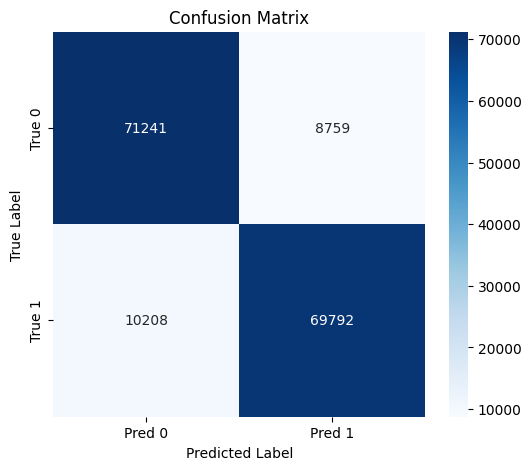

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

print("Confusion Matrix (raw values):")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import torch
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

all_texts = []
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Collecting errors"):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs["logits"] if isinstance(outputs, dict) else outputs.logits
        probs = torch.softmax(logits, dim=1)

        preds = torch.argmax(logits, dim=1)

        # Store results
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())


In [ ]:
all_texts = [
    tokenizer.decode(test_dataset[i]["input_ids"], skip_special_tokens=True)
    for i in range(len(test_dataset))
]

In [ ]:
# BUILD MISCLASSIFIED LIST

misclassified = []

for text, true_label, pred_label, prob in zip(all_texts, all_labels, all_preds, all_probs):
    if true_label != pred_label:
        misclassified.append({
            "text": text,
            "true": int(true_label),
            "pred": int(pred_label),
            "prob": float(prob)
        })

print("Total misclassified samples:", len(misclassified))


Total misclassified samples: 18967


In [ ]:
# SAMPLE 50 MISCLASSIFIED

random.seed(42)
sample_errors = random.sample(misclassified, min(500, len(misclassified)))

In [ ]:
# CATEGORIZATION HEURISTICS

def categorize_error(text):
    t = text.lower()

    # 1. Sarcasm
    sarcasm_markers = ["yeah right", "sure", "totally", "/s", "as if", "great...", "love that for me"]
    if any(s in t for s in sarcasm_markers):
        return "sarcasm"

    # 2. Negation
    if "not " in t or "n't " in t:
        return "negation"

    # 3. OOV / Slang / Emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               "]+", flags=re.UNICODE)
    slang = ["idk", "imo", "lmao", "omg", "fr", "ngl", "smh"]
    if emoji_pattern.search(text) or any(s in t for s in slang):
        return "oov_slang"

    # 4. Multi-topic
    if text.count(".") > 1 or (" and " in t and len(text.split()) > 20):
        return "multi_topic"

    # 5. Domain drift
    domain_terms = ["crypto", "elon", "ai", "nft", "stocks", "fed", "inflation"]
    if any(d in t for d in domain_terms):
        return "domain_drift"

    return "other"


# Organize categories
categories = {
    "sarcasm": [],
    "negation": [],
    "oov_slang": [],
    "multi_topic": [],
    "domain_drift": [],
    "other": []
}

for item in sample_errors:
    cat = categorize_error(item["text"])
    categories[cat].append(item)


In [ ]:
# PRINT REQUIRED OUTPUT

def show_category(cat_name, display_name, explanation, fix):
    print("\n==============================================================")
    print(f"### {display_name.upper()}")
    print("Why the model failed:", explanation)
    print("How to fix it:", fix)

    examples = categories[cat_name][:2]
    for ex in examples:
        print("\n--- Tweet Example ---")
        print(ex["text"])
        print("True Label:", ex["true"], " Pred:", ex["pred"], " Prob:", round(ex["prob"], 3))


show_category(
    "sarcasm",
    "Sarcasm",
    "Sarcasm expresses opposite meaning, confusing literal sentiment models.",
    "Train on sarcasm datasets, add sarcasm markers, or use context-aware models."
)

show_category(
    "negation",
    "Negation Errors",
    "Model picks up sentiment words but ignores negation cues ('not happy').",
    "Use negation-aware augmentation and dependency parsing."
)

show_category(
    "oov_slang",
    "OOV / Slang / Emojis",
    "Tweet uses slang/emojis not in pretrained vocabulary, losing sentiment cues.",
    "Use BERTweet tokenizer, emoji embeddings, or slang normalization."
)

show_category(
    "multi_topic",
    "Multi-topic Tweets",
    "Tweets contain multiple conflicting sentiments; model forces binary decision.",
    "Use multi-label models or sentence-level sentiment decomposition."
)

show_category(
    "domain_drift",
    "Domain Drift",
    "Model was trained on general data but tweet refers to domain-specific contexts.",
    "Fine-tune on domain-specific corpora or adopt adapter layers."
)

print("\nError analysis complete.")


### SARCASM
Why the model failed: Sarcasm expresses opposite meaning, confusing literal sentiment models.
How to fix it: Train on sarcasm datasets, add sarcasm markers, or use context-aware models.

--- Tweet Example ---
angels demons is brilliant! though not sure 3weeks after an operation 2hrs in a cinema seat was my most brilliant idea!
True Label: 0  Pred: 1  Prob: 0.902

--- Tweet Example ---
 sis we totally were not on twitter simultaneously last night must do better today! or tonight ! 
True Label: 1  Pred: 0  Prob: 0.177

### NEGATION ERRORS
Why the model failed: Model picks up sentiment words but ignores negation cues ('not happy').
How to fix it: Use negation-aware augmentation and dependency parsing.

--- Tweet Example ---
 i did not say it she <shout> did <shout> !  seriously and how do i break it to her that she s my daughter and will not ever <shout> be that tan ? 
True Label: 1  Pred: 0  Prob: 0.019

--- Tweet Example ---
 fuck ya nice let me know how that goes i am doin